In [49]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

from src.utils.feature_engineering import compute_ratio_columnwise

In [99]:
#Training Data
app_train = pd.read_csv('../data/raw/app_train.csv')
#app_test  = pd.read_csv('../data/raw/app_test.csv')


In [100]:
categorical_features = ['FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE',\
                        'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_HOUSING_TYPE',\
                        'WEEKDAY_APPR_PROCESS_START','ORGANIZATION_TYPE',]

numerical_features =   ['CNT_CHILDREN','FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_EMAIL',\
                       'CNT_FAM_MEMBERS','REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY','REG_REGION_NOT_LIVE_REGION',\
                       'REG_REGION_NOT_WORK_REGION','DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE','FLAG_DOCUMENT_2',\
                       'FLAG_DOCUMENT_3','FLAG_DOCUMENT_6','FLAG_DOCUMENT_8','AMT_REQ_CREDIT_BUREAU_HOUR',\
                       'AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_QRT',\
                        'REGION_POPULATION_RELATIVE','employment_years','DAYS_REGISTRATION','DAYS_ID_PUBLISH',\
                        'HOUR_APPR_PROCESS_START','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_LAST_PHONE_CHANGE',\
                        'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_YEAR',\
                        'AMT_CREDIT_AMT_INCOME_TOTAL_ratio','Client_Age','AMT_ANNUITY_AMT_INCOME_TOTAL_ratio',\
                        'AMT_CREDIT_AMT_GOODS_PRICE_ratio','employment_age']


Target = "TARGET"

primary_key = "SK_ID_CURR" 


In [101]:
def app_data_processing(df):
    # Lets remove CODE_GENDER=XNA
    df = df.loc[df['CODE_GENDER'] != 'XNA']
    # Apply function
    df['AMT_ANNUITY_AMT_INCOME_TOTAL_ratio'] = compute_ratio_columnwise(df, 'AMT_ANNUITY', 'AMT_INCOME_TOTAL')
    # Apply function
    df['AMT_CREDIT_AMT_INCOME_TOTAL_ratio'] = compute_ratio_columnwise(df, 'AMT_CREDIT', 'AMT_INCOME_TOTAL')
    # Apply function
    df['AMT_CREDIT_AMT_GOODS_PRICE_ratio'] = compute_ratio_columnwise(df, 'AMT_CREDIT', 'AMT_GOODS_PRICE')
    df["Client_Age"] = (df["DAYS_BIRTH"]/(-365)).round(2)
    df['employment_years'] = np.where(df['DAYS_EMPLOYED'] < 0,  (df["DAYS_EMPLOYED"] / -365).round(2),  np.nan)
    df["employment_age"] = np.where(df["employment_years"].isna(),  -1,  
                              np.where(df["Client_Age"] > df["employment_years"],\
                                        df["Client_Age"] - df["employment_years"], -2) 
                                # f1 > f2 -> f1 - f2, else NaN
                                )
    df['AMT_CREDIT_AMT_ANNUITY_ratio'] = compute_ratio_columnwise(df, 'AMT_CREDIT', 'AMT_ANNUITY')     
    df = df[categorical_features + numerical_features + [Target,primary_key]] 
    df[categorical_features] = df[categorical_features].astype('category')
    

    return df                     

In [102]:
app_train= app_data_processing(app_train)
#app_test = app_data_processing(app_test)

In [8]:
app_train.shape


(215255, 47)

### SHAP-BASED Feature SELECTION
SHAP (SHapley Additive exPlanations) values provide one of the most robust approaches for feature selection with XGBoost.


In [54]:
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from src.utils.feature_selection import shap_feature_selection


In [7]:
features=numerical_features+categorical_features
Target = "TARGET"

In [8]:
selected_features,importance_df =shap_feature_selection(train_data=app_train,feature_names=features,target_name=Target,verbose=True)

scale_pos_weight: 11.3874
Detected 8 categorical features: ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']
[0]	validation_0-aucpr:0.17089
[1]	validation_0-aucpr:0.17941
[2]	validation_0-aucpr:0.17951
[3]	validation_0-aucpr:0.18220
[4]	validation_0-aucpr:0.18609
[5]	validation_0-aucpr:0.18949
[6]	validation_0-aucpr:0.18966
[7]	validation_0-aucpr:0.18989
[8]	validation_0-aucpr:0.19048
[9]	validation_0-aucpr:0.19219
[10]	validation_0-aucpr:0.19327
[11]	validation_0-aucpr:0.19558
[12]	validation_0-aucpr:0.19682
[13]	validation_0-aucpr:0.19788
[14]	validation_0-aucpr:0.19880
[15]	validation_0-aucpr:0.20113
[16]	validation_0-aucpr:0.20143
[17]	validation_0-aucpr:0.20241
[18]	validation_0-aucpr:0.20436
[19]	validation_0-aucpr:0.20534
[20]	validation_0-aucpr:0.20572
[21]	validation_0-aucpr:0.20561
[22]	validation_0-aucpr:0.20656
[23]	validation_0-aucpr:0.20742
[24]	validati

In [10]:
app_train[selected_features].dtypes

EXT_SOURCE_3                           float64
EXT_SOURCE_2                           float64
EXT_SOURCE_1                           float64
AMT_CREDIT_AMT_GOODS_PRICE_ratio       float64
employment_years                       float64
ORGANIZATION_TYPE                     category
NAME_EDUCATION_TYPE                   category
Client_Age                             float64
AMT_ANNUITY_AMT_INCOME_TOTAL_ratio     float64
FLAG_OWN_CAR                          category
DAYS_ID_PUBLISH                          int64
FLAG_DOCUMENT_3                          int64
REGION_RATING_CLIENT_W_CITY              int64
DEF_30_CNT_SOCIAL_CIRCLE               float64
DAYS_LAST_PHONE_CHANGE                 float64
dtype: object

In [31]:
importance_df

,Feature,SHAP_Importance,Relative_Importance,Cumulative_Importance
28,EXT_SOURCE_3,0.387778,0.249861,0.249861
27,EXT_SOURCE_2,0.320375,0.206430,0.456291
26,EXT_SOURCE_1,0.168750,0.108732,0.565023
35,AMT_CREDIT_AMT_GOODS_PRICE_ratio,0.131068,0.084452,0.649476
22,employment_years,0.111680,0.071960,0.721435
44,ORGANIZATION_TYPE,0.100662,0.064861,0.786296
41,NAME_EDUCATION_TYPE,0.089892,0.057921,0.844217
33,Client_Age,0.035112,0.022624,0.866841
34,AMT_ANNUITY_AMT_INCOME_TOTAL_ratio,0.034967,0.022530,0.889372
37,FLAG_OWN_CAR,0.020403,0.013146,0.902518


### XGBoost Model with Selected Features


In [55]:
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,accuracy_score, classification_report
from src.utils.feature_selection import shap_feature_selection

In [56]:
selected_features=['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'AMT_CREDIT_AMT_GOODS_PRICE_ratio',
 'employment_years',
 'ORGANIZATION_TYPE',
 'NAME_EDUCATION_TYPE',
 'Client_Age']

"""
 'AMT_ANNUITY_AMT_INCOME_TOTAL_ratio',
 'FLAG_OWN_CAR',
 'DAYS_ID_PUBLISH',
 'FLAG_DOCUMENT_3',
 'REGION_RATING_CLIENT_W_CITY',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE'
"""

"\n 'AMT_ANNUITY_AMT_INCOME_TOTAL_ratio',\n 'FLAG_OWN_CAR',\n 'DAYS_ID_PUBLISH',\n 'FLAG_DOCUMENT_3',\n 'REGION_RATING_CLIENT_W_CITY',\n 'DEF_30_CNT_SOCIAL_CIRCLE',\n 'DAYS_LAST_PHONE_CHANGE'\n"

In [57]:
X = app_train[selected_features]
y = app_train['TARGET']
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [58]:
# Build model with scikit-learn API
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    learning_rate=0.01,
    max_depth=4,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    scale_pos_weight=sum(y_train==0)/sum(y_train==1),
    enable_categorical=True,  # Enable categorical features
    random_state=42,
    early_stopping_rounds=20,
)

# Train with early stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],  
    verbose=20
)


[0]	validation_0-auc:0.67539
[20]	validation_0-auc:0.72412
[31]	validation_0-auc:0.72615


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=20,
              enable_categorical=True, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [59]:
from src.utils.other_utils import save_object, load_object

In [60]:
model_file ="../models/xgboost_model.pkl"
save_object(obj=model,file_path=model_file)

[ 2025-03-08 16:38:43,464 ] 52 src.logging.custom_logging - INFO - Entered the save_object method of Utils class
[ 2025-03-08 16:38:43,477 ] 60 src.logging.custom_logging - INFO - Successfully saved object to ../models/xgboost_model.pkl


In [13]:
# Feature importance
importance = model.get_booster().get_score(importance_type='gain')
importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))
importance

{'EXT_SOURCE_3': 3169.408447265625,
 'EXT_SOURCE_2': 1834.6593017578125,
 'employment_years': 862.74755859375,
 'EXT_SOURCE_1': 633.1666259765625,
 'NAME_EDUCATION_TYPE': 561.3301391601562,
 'Client_Age': 470.93865966796875,
 'AMT_CREDIT_AMT_GOODS_PRICE_ratio': 380.2223205566406,
 'ORGANIZATION_TYPE': 348.52679443359375}

,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,AMT_CREDIT_AMT_GOODS_PRICE_ratio,employment_years,ORGANIZATION_TYPE,NAME_EDUCATION_TYPE,Client_Age
199384,NaN,0.727534,NaN,1.13,11.9,Industry: type 5,Secondary / secondary special,39.78


## Combined Performance of Train/Test/OOT


In [61]:
from src.utils.other_utils import eqLinear, three_digit_score

In [62]:
# Create train DataFrame
df_train = X_train.copy()
df_train["y_true"] = y_train
y_pred_prob_train = model.predict_proba(X_train)[:, 1]  # probability of 1 i.e default
df_train["y_pred_prob"] = y_pred_prob_train
df_train["dataset"] = "train"  # Add identifier

# Create test DataFrame
df_test = X_test.copy()
df_test["y_true"] = y_test
y_pred_prob_test = model.predict_proba(X_test)[:, 1]  # probability of 1 i.e default
df_test["y_pred_prob"] = y_pred_prob_test
df_test["dataset"] = "test"  # Add identifier

base_pd = df_train.y_true.mean() #Reference probability of default (default 2%)
OddsAtAnchor = (1-base_pd)/base_pd

eqLinParams= eqLinear(OddsAtAnchor=base_pd,PDO=50)
alpha = eqLinParams['alpha']
print(alpha)
beta  = eqLinParams['beta']
print(beta)


# Concatenate both DataFrames
df_combined = pd.concat([df_train, df_test], axis=0, ignore_index=True)
# Apply score conversion
df_combined['three_digit_score'] = three_digit_score(df_combined['y_pred_prob'], alpha=alpha, beta=beta)


# Optional: Free up memory
del  df_train,df_test
import gc
gc.collect()



781.539
72.1348


314

#### Combined performance

In [16]:
from src.utils.evaluation_metrics import *

In [227]:
##Combined Performance
train_breaks = calculate_breaks(data=df_combined[df_combined['dataset']=='train'], 
                                score='y_pred_prob',numOfIntervals=10)

In [228]:
custom_segments = calculate_performance_metrics(
    data=df_combined,
    score_col='y_pred_prob',
    target_col='y_true',
    segments='dataset',
    breaks=train_breaks
)
custom_segments

,KS,ROC_AUC,GINI
train,34.90,73.73,47.46
test,32.92,72.64,45.29


### Gains Table 

In [68]:
Train_GT= gainTable(data=df_combined[df_combined['dataset']=='train'],response_name=['Bad','Good'],
                    score='y_pred_prob',ground_truth='y_true',numOfIntervals=10,
                    is_score_prob=True)
Train_GT['GainTable']

,Score_Range,Totals,Good,Good_Rate,CumGood,Bad,Bad_Rate,CumBad,KS,AvgScore,Lift
0,"(0.516, inf]",15069,11317,75.10,8.17,3752,24.90,30.85,22.68,0.52,3.08
1,"(0.509, 0.516]",15071,12928,85.78,17.50,2143,14.22,48.46,30.96,0.51,2.42
2,"(0.504, 0.509]",15180,13516,89.04,27.26,1664,10.96,62.14,34.88,0.51,2.07
3,"(0.498, 0.504]",14979,13768,91.92,37.20,1211,8.08,72.10,34.90,0.50,1.80
4,"(0.493, 0.498]",15060,14088,93.55,47.37,972,6.45,80.09,32.72,0.50,1.60
5,"(0.488, 0.493]",15048,14283,94.92,57.68,765,5.08,86.38,28.70,0.49,1.44
6,"(0.483, 0.488]",15068,14486,96.14,68.14,582,3.86,91.16,23.02,0.49,1.30
7,"(0.479, 0.483]",15080,14601,96.82,78.68,479,3.18,95.10,16.42,0.48,1.19
8,"(0.474, 0.479]",15056,14687,97.55,89.29,369,2.45,98.13,8.84,0.48,1.09
9,"(-inf, 0.474]",15067,14840,98.49,100.00,227,1.51,100.00,0.00,0.47,1.00


In [69]:
train_brk=Train_GT['breaks']

In [71]:
train_brk


array([      -inf, 0.47352275, 0.47873222, 0.48297344, 0.48838336,
       0.49314939, 0.49781528, 0.50354295, 0.50873427, 0.51592865,
              inf])

In [231]:
Test_GT= gainTable(data=df_combined[df_combined['dataset']=='test'],response_name=['Bad','Good'],
                    score='y_pred_prob',ground_truth='y_true',numOfIntervals=10,
                    is_score_prob=False,breaks=train_brk)
Test_GT['GainTable']

,Score_Range,Totals,Good,Good_Rate,CumGood,Bad,Bad_Rate,CumBad,KS,AvgScore,Lift
0,"(0.516, inf]",6352,4788,75.38,8.07,1564,24.62,30.00,21.93,0.52,3.05
1,"(0.509, 0.516]",6594,5680,86.14,17.63,914,13.86,47.54,29.91,0.51,2.37
2,"(0.504, 0.509]",6484,5816,89.70,27.43,668,10.30,60.35,32.92,0.51,2.01
3,"(0.498, 0.504]",6378,5871,92.05,37.32,507,7.95,70.07,32.75,0.50,1.75
4,"(0.493, 0.498]",6493,6042,93.05,47.50,451,6.95,78.73,31.23,0.50,1.57
5,"(0.488, 0.493]",6379,6056,94.94,57.70,323,5.06,84.92,27.22,0.49,1.42
6,"(0.483, 0.488]",6505,6216,95.56,68.17,289,4.44,90.47,22.30,0.49,1.29
7,"(0.479, 0.483]",6380,6186,96.96,78.59,194,3.04,94.19,15.60,0.48,1.18
8,"(0.474, 0.479]",6382,6202,97.18,89.04,180,2.82,97.64,8.60,0.48,1.09
9,"(-inf, 0.474]",6630,6507,98.14,100.00,123,1.86,100.00,0.00,0.47,1.00


In [232]:
Train_GT= gainTable(data=df_combined[df_combined['dataset']=='train'],response_name=['Bad','Good'],
                    score='three_digit_score',ground_truth='y_true',numOfIntervals=10,
                    is_score_prob=False)
Train_GT['GainTable']

,Score_Range,Totals,Good,Good_Rate,CumGood,Bad,Bad_Rate,CumBad,KS,AvgScore,Lift
0,"(-inf, 776.0]",12457,9224,74.05,6.66,3233,25.95,26.58,19.92,774.45,3.22
1,"(776.0, 778.0]",14775,12464,84.36,15.66,2311,15.64,45.58,29.92,777.50,2.52
2,"(778.0, 780.0]",17656,15678,88.80,26.98,1978,11.20,61.84,34.86,779.60,2.08
3,"(780.0, 782.0]",18648,17169,92.07,39.37,1479,7.93,74.00,34.63,781.48,1.75
4,"(782.0, 783.0]",11601,10866,93.66,47.22,735,6.34,80.04,32.82,783.00,1.61
5,"(783.0, 784.0]",11317,10718,94.71,54.95,599,5.29,84.96,30.01,784.00,1.48
6,"(784.0, 786.0]",19698,18921,96.06,68.61,777,3.94,91.35,22.74,785.50,1.30
7,"(786.0, 787.0]",12459,12056,96.77,77.32,403,3.23,94.66,17.34,787.00,1.20
8,"(787.0, 789.0]",19557,19068,97.50,91.08,489,2.50,98.68,7.60,788.47,1.08
9,"(789.0, inf]",12510,12350,98.72,100.00,160,1.28,100.00,0.00,790.80,1.00


In [234]:
Train_GT['breaks']

array([-inf, 776., 778., 780., 782., 783., 784., 786., 787., 789.,  inf])

### Model Explainable using Shap

In [17]:
import matplotlib.pyplot as plt

In [63]:
# Initialize SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)


In [64]:
model_file ="../models/explainer.pkl"
save_object(obj=explainer,file_path=model_file)

[ 2025-03-08 16:38:59,120 ] 52 src.logging.custom_logging - INFO - Entered the save_object method of Utils class
[ 2025-03-08 16:38:59,148 ] 60 src.logging.custom_logging - INFO - Successfully saved object to ../models/explainer.pkl


### Summary Plot

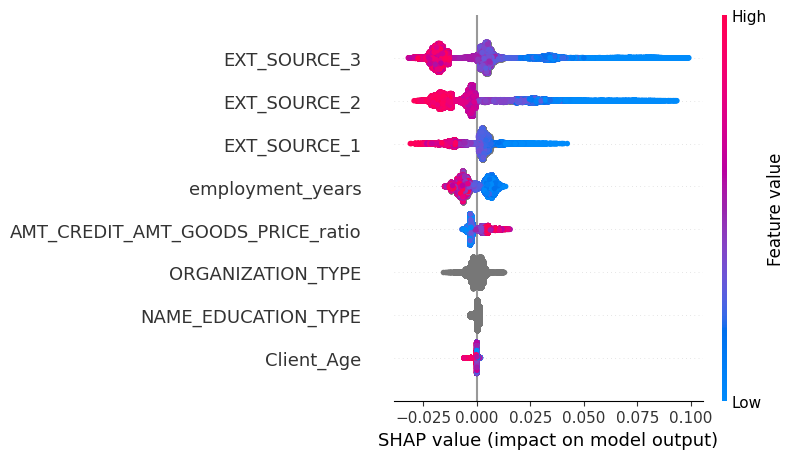

In [129]:
shap.summary_plot(shap_values)

### Dependence Plot

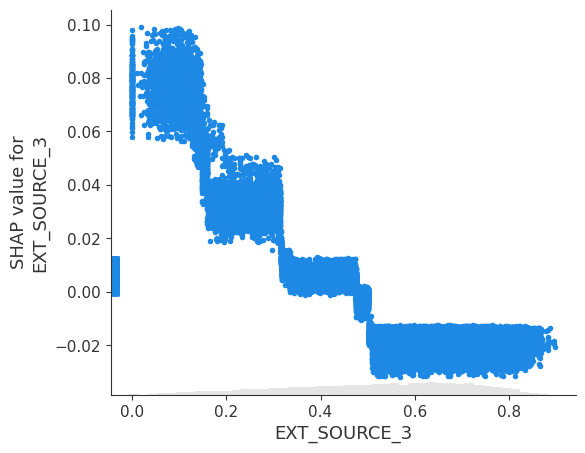

In [130]:
# Create a dependence plot for a single feature
shap.plots.scatter(shap_values[:, "EXT_SOURCE_3"])

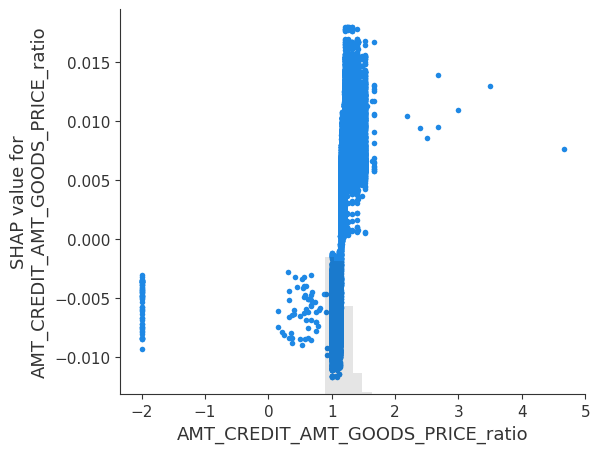

In [67]:
# Create a dependence plot for a single feature
shap.plots.scatter(shap_values[:, "AMT_CREDIT_AMT_GOODS_PRICE_ratio"])

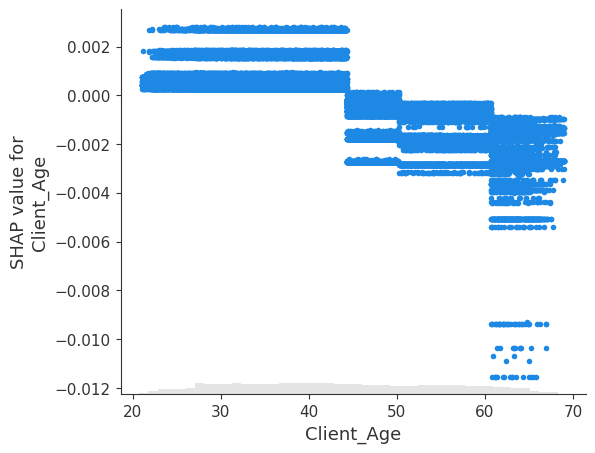

In [70]:
# Create a dependence plot for a single feature
shap.plots.scatter(shap_values[:, "Client_Age"])

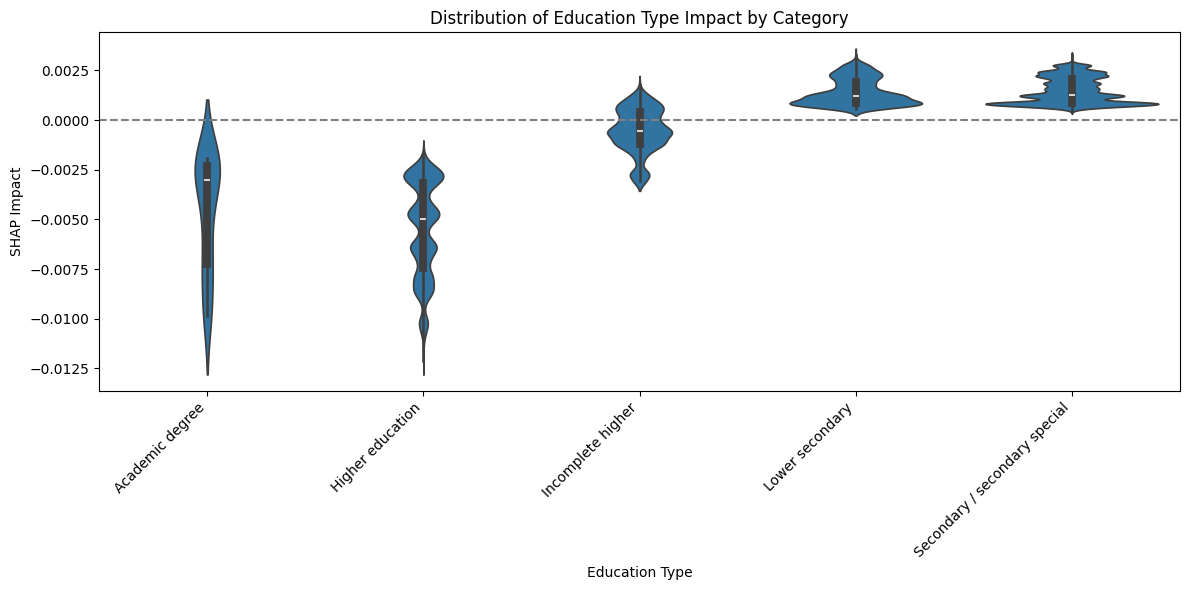

In [73]:
# Create a DataFrame with the SHAP values and categories
# Extract SHAP values for the categorical feature
shap_df = pd.DataFrame({
    'Category': X_test["NAME_EDUCATION_TYPE"],
    'SHAP_value': shap_values[:, "NAME_EDUCATION_TYPE"].values
})

# Group by category and plot
grouped_shap = shap_df.groupby('Category')['SHAP_value'].mean().sort_values()

# For a more detailed view, create a violin plot
plt.figure(figsize=(12, 6))
import seaborn as sns
sns.violinplot(x='Category', y='SHAP_value', data=shap_df)
plt.axhline(y=0, color='gray', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Education Type")
plt.ylabel("SHAP Impact")
plt.title("Distribution of Education Type Impact by Category")
plt.tight_layout()
plt.show()

#### Explain Individual Predictions

In [188]:
explainer.expected_value

np.float32(-5.0314968e-05)

In [189]:
log_odds = explainer.expected_value # Your SHAP expected value
probability = 1 / (1 + np.exp(-log_odds))
print(probability)  # Converts log-odds to probability

0.49998742


In [218]:
#Example 1
prob = df_combined[df_combined['y_pred_prob']>0.5].iloc[[3]].y_pred_prob
print(f" probability : { prob }")
log_odds = np.log((prob)/(1-prob))
print(f" log_odd : { log_odds }")

 probability : 5    0.502337
Name: y_pred_prob, dtype: float32
 log_odd : 5    0.009347
Name: y_pred_prob, dtype: float32


In [65]:
x_selected_bad = df_combined[df_combined['y_pred_prob']>0.5][selected_features].iloc[[3]]

In [ ]:
explainer.expected_value+explainer.shap_values(x_selected_bad)[0,:].sum()

np.float32(0.009346662)

In [180]:
#Example 2
prob = df_combined[df_combined['y_pred_prob']<0.46].iloc[[3]].y_pred_prob
log_odds = np.log((prob)/(1-prob))
log_odds

607   -0.163498
Name: y_pred_prob, dtype: float32

In [ ]:
x_selected_good = df_combined[df_combined['y_pred_prob']<0.46][selected_features].iloc[[3]]

In [181]:
explainer.expected_value+explainer.shap_values(x_selected_good)[0,:].sum()

np.float32(-0.16349822)

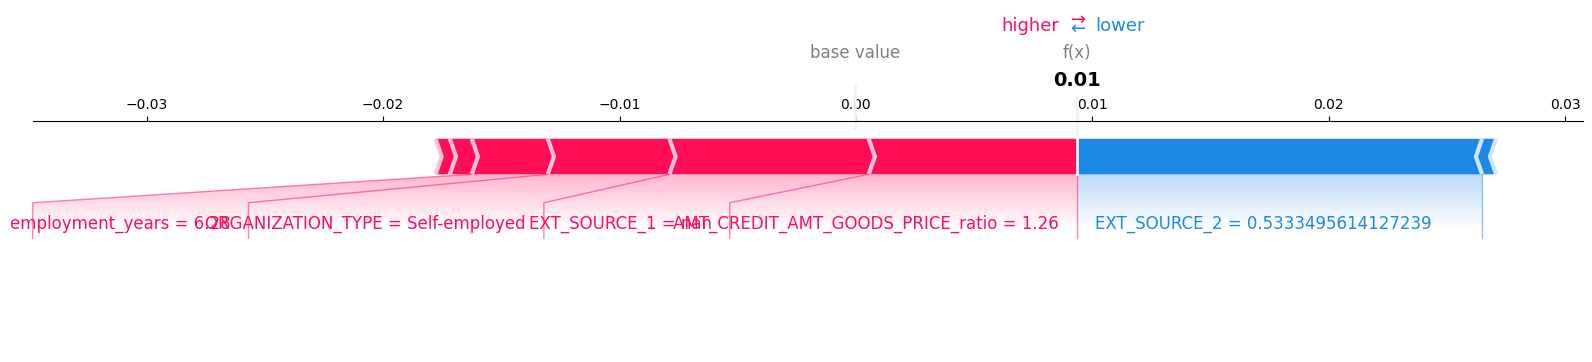

In [112]:
# Force plot for the first observation
shap.force_plot(
    explainer.expected_value,  # Base value (average prediction)
    explainer.shap_values(x_selected_bad)[0,:],  # SHAP values for the observation
    x_selected_bad.iloc[0,:],  # Feature values for the observation
    matplotlib=True  # Display the plot inline
)

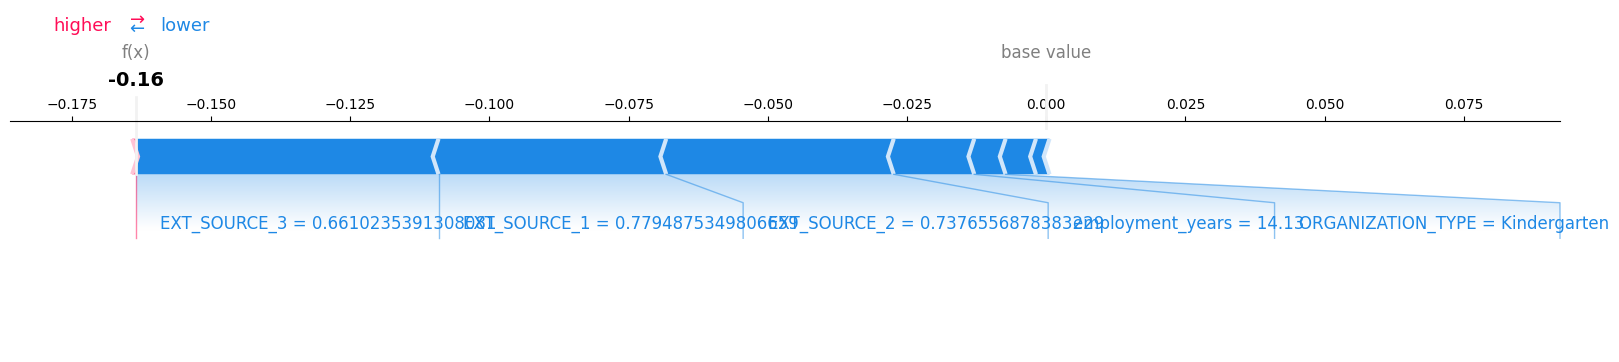

In [113]:
# Force plot for the first observation
shap.force_plot(
    explainer.expected_value,  # Base value (average prediction)
    explainer.shap_values(x_selected_good)[0,:],  # SHAP values for the observation
    x_selected_good.iloc[0,:],  # Feature values for the observation
    matplotlib=True  # Display the plot inline
)

In [207]:

# Create a DataFrame with SHAP values and feature names
pd.DataFrame(explainer.shap_values(x_selected_bad), columns=x_selected_bad.columns).T.sort_values(by=0, ascending=True)

,0
EXT_SOURCE_2,-0.017138
Client_Age,-0.000593
EXT_SOURCE_3,0.000604
NAME_EDUCATION_TYPE,0.000929
employment_years,0.003215
ORGANIZATION_TYPE,0.005145
EXT_SOURCE_1,0.008427
AMT_CREDIT_AMT_GOODS_PRICE_ratio,0.008807


In [91]:
# Create a DataFrame with SHAP values and feature names
pd.DataFrame(explainer.shap_values(x_selected_good), columns=x_selected_good.columns).T

,0
EXT_SOURCE_3,0.061398
EXT_SOURCE_2,-0.018996
EXT_SOURCE_1,0.008630
AMT_CREDIT_AMT_GOODS_PRICE_ratio,-0.003579
employment_years,0.012190
ORGANIZATION_TYPE,-0.004097
NAME_EDUCATION_TYPE,0.002139
Client_Age,0.000410


KS/GINI/roc_auc_score/confusion Matrix /Precision-Recall/F1-score/ROC AUC Plot/LIFT CHART/Precision-Recall curve
3-digit score 
gains table
#### calibration checks
##

In [157]:
shap_values = explainer.shap_values(X_train)

In [158]:
# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

In [67]:
y_pred_b= model.predict_proba(X_test)[:,1]

In [69]:
len(y_pred_b)

64577

In [72]:
auc_b = roc_auc_score(y_test,y_pred_b)
auc_b

np.float64(0.7449753409082805)

In [75]:
model_s = xgb.XGBClassifier(
                n_estimators=100, 
                learning_rate=0.05,
                max_depth=4,
                random_state=42,
                eval_metric = 'aucpr',enable_categorical=True)
    
model_s.fit(X_train[selected_features], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [76]:
y_pred_a= model_s.predict_proba(X_test[selected_features])[:,1]

In [77]:
auc_a = roc_auc_score(y_test,y_pred_a)
auc_a

np.float64(0.7442115977000661)

In [89]:
explainer = shap.TreeExplainer(model_s)

In [91]:
shap_values = explainer.shap_values(X_test[selected_features])

In [93]:
shap_values.shape

(64577, 13)

tuple

In [95]:
# print the JS visualization code to the notebook
shap.initjs()

In [96]:
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test[selected_features].iloc[0, :])

In [ ]:
1/(1+np.exp(- explainer.shap_values(X_test[selected_features].iloc[0:1,:])))


array([[0.5164693 , 0.39846978, 0.5098487 , 0.4906576 , 0.5201898 ,
        0.4822249 , 0.5130377 , 0.48086444, 0.5076199 , 0.48663962,
        0.4956851 , 0.5012622 , 0.4726498 ]], dtype=float32)

In [144]:

explainer.shap_values(X_test[selected_features].iloc[0:1,:])

array([[ 0.0659011 , -0.41184515,  0.03939995, -0.03737412,  0.0808033 ,
        -0.07113039,  0.05216241, -0.07657965,  0.03048193, -0.05345416,
        -0.01726007,  0.0050488 , -0.10951001]], dtype=float32)

In [115]:
selected_features

['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'AMT_CREDIT_AMT_GOODS_PRICE_ratio',
 'ORGANIZATION_TYPE',
 'employment_years',
 'NAME_EDUCATION_TYPE',
 'Client_Age',
 'AMT_ANNUITY_AMT_INCOME_TOTAL_ratio',
 'FLAG_DOCUMENT_3',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_OWN_CAR',
 'REGION_RATING_CLIENT_W_CITY']

In [113]:
explainer.expected_value-0.50335604

np.float32(-2.947559)

In [146]:

def log_odds_to_probability(log_odds):
    return 1 / (1 + np.exp(-log_odds))

# Example
log_odds = -0.10951001 # Example log-odds value
probability = log_odds_to_probability(log_odds)
print(probability)  # Output: ~0.88

0.47264982498803393


In [134]:
#y_test.mean()
0.07987842623285228-0.04973651155855672


0.030141914674295563

In [139]:
-0.50335604+(-2.444)

-2.94735604

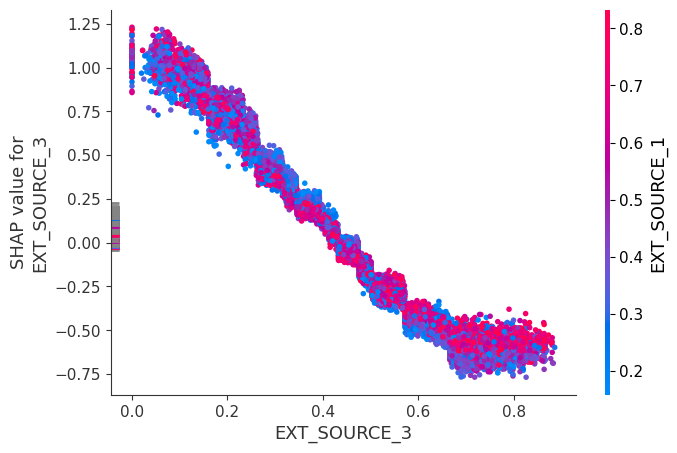

In [97]:
shap.dependence_plot('EXT_SOURCE_3', shap_values, X_test[selected_features], display_features=X_test[selected_features])

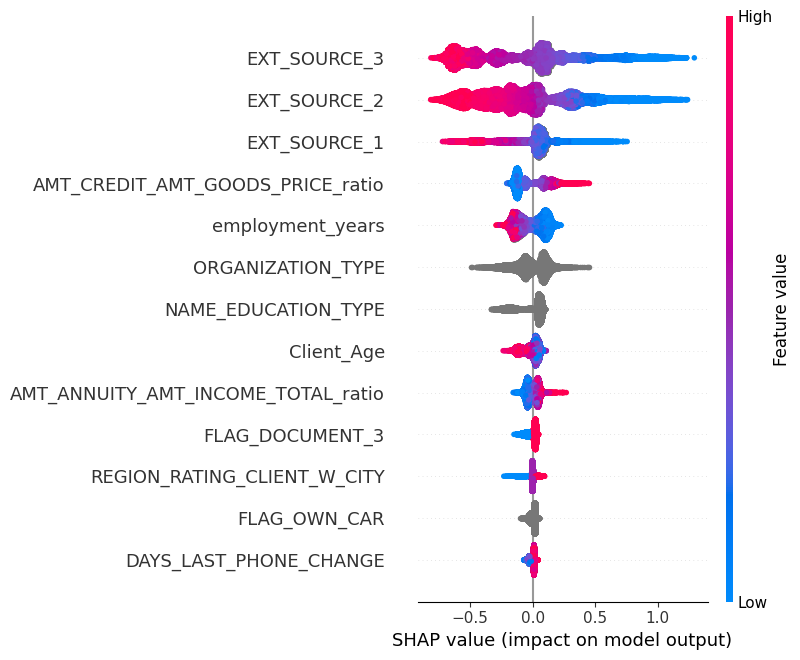

In [92]:
# Visualize feature importance based on SHAP
shap.summary_plot(shap_values, X_test[selected_features])

In [84]:
### Kaggle Test Data score check
test_kaggle = pd.read_csv("../data/raw/application_test.csv")
test_kaggle['TARGET']=0

In [85]:
test_kaggle = app_data_processing(test_kaggle)
#app_test = app_data_processing(app_test)

In [86]:
y_pred_k= model_s.predict_proba(test_kaggle[selected_features])[:,1]

In [88]:
submit=test_kaggle[["SK_ID_CURR"]]
submit['TARGET']=y_pred_k
submit.to_csv('../data/Kaggle_submission/1.XGB_baseline_app_features.csv',index=False)